<p style="color: Gold; font-size: 40px;"><strong>Porto Seguro’s Safe Driver Prediction</strong></p>

**Kaggle Link: https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data**

# **Step 1: Libraries**

In [1]:
import sys
sys.path.append('../Utils')
from meta import meta
from target_encoding import target_encode

# Data Science Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set_theme()

# Missing Values
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

# Imbalanced Data
import imblearn
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

# Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

# **Step 2: EDA**

**Load Data**

In [2]:
df_train = pd.read_csv("../Data/train.csv")
df_test = pd.read_csv("../Data/test.csv")
fullset = pd.concat([df_train, df_test], ignore_index=True)

## Missing Values

In [3]:
metadata = meta(df_train, df_test)
metadata

,role,category,level,dtype,cardinality,cardinality_level,missing,missing_percent,imputation,keep
colname,,,,,,,,,,
id,id,other,nominal,int64,Ignore,Ignore,0,0(0.0%),No Missing,False
target,target,other,binary,object,Ignore,Ignore,0,0(0.0%),No Missing,True
ps_ind_01,feature,individual,ordinal,int64,8,Low Cardinality,0,0(0.0%),No Missing,True
ps_ind_02_cat,feature,individual,nominal,int64,4,Low Cardinality,523,523(0.04%),mode,True
ps_ind_03,feature,individual,ordinal,int64,12,Medium Cardinality,0,0(0.0%),No Missing,True
ps_ind_04_cat,feature,individual,nominal,int64,2,Low Cardinality,228,228(0.02%),mode,True
ps_ind_05_cat,feature,individual,nominal,int64,7,Low Cardinality,14519,14519(0.98%),mode,True
ps_ind_06_bin,feature,individual,binary,int64,2,Low Cardinality,0,0(0.0%),No Missing,True
ps_ind_07_bin,feature,individual,binary,int64,2,Low Cardinality,0,0(0.0%),No Missing,True


In [4]:
metadata.groupby(['role','level']).size().reset_index(name = 'count')

,role,level,count
0,feature,binary,17
1,feature,interval,5
2,feature,nominal,14
3,feature,ordinal,16
4,feature,ratio,5
5,id,nominal,1
6,target,binary,1


In [5]:
missing_data = metadata[['missing','missing_percent','imputation']][metadata['missing']>0].sort_values(by = 'missing', ascending=False)
missing_data

,missing,missing_percent,imputation
colname,,,
ps_car_03_cat,1028142,1028142(69.09%),remove
ps_car_05_cat,666910,666910(44.82%),remove
ps_reg_03,269456,269456(18.11%),"(mode, median, mean)"
ps_car_14,106425,106425(7.15%),"(mode, median, mean)"
ps_car_07_cat,28820,28820(1.94%),mode
ps_ind_05_cat,14519,14519(0.98%),mode
ps_car_09_cat,1446,1446(0.1%),mode
ps_ind_02_cat,523,523(0.04%),mode
ps_car_01_cat,267,267(0.02%),mode


In [6]:
cols_to_imp = missing_data.index[2:].to_list()

<Axes: >

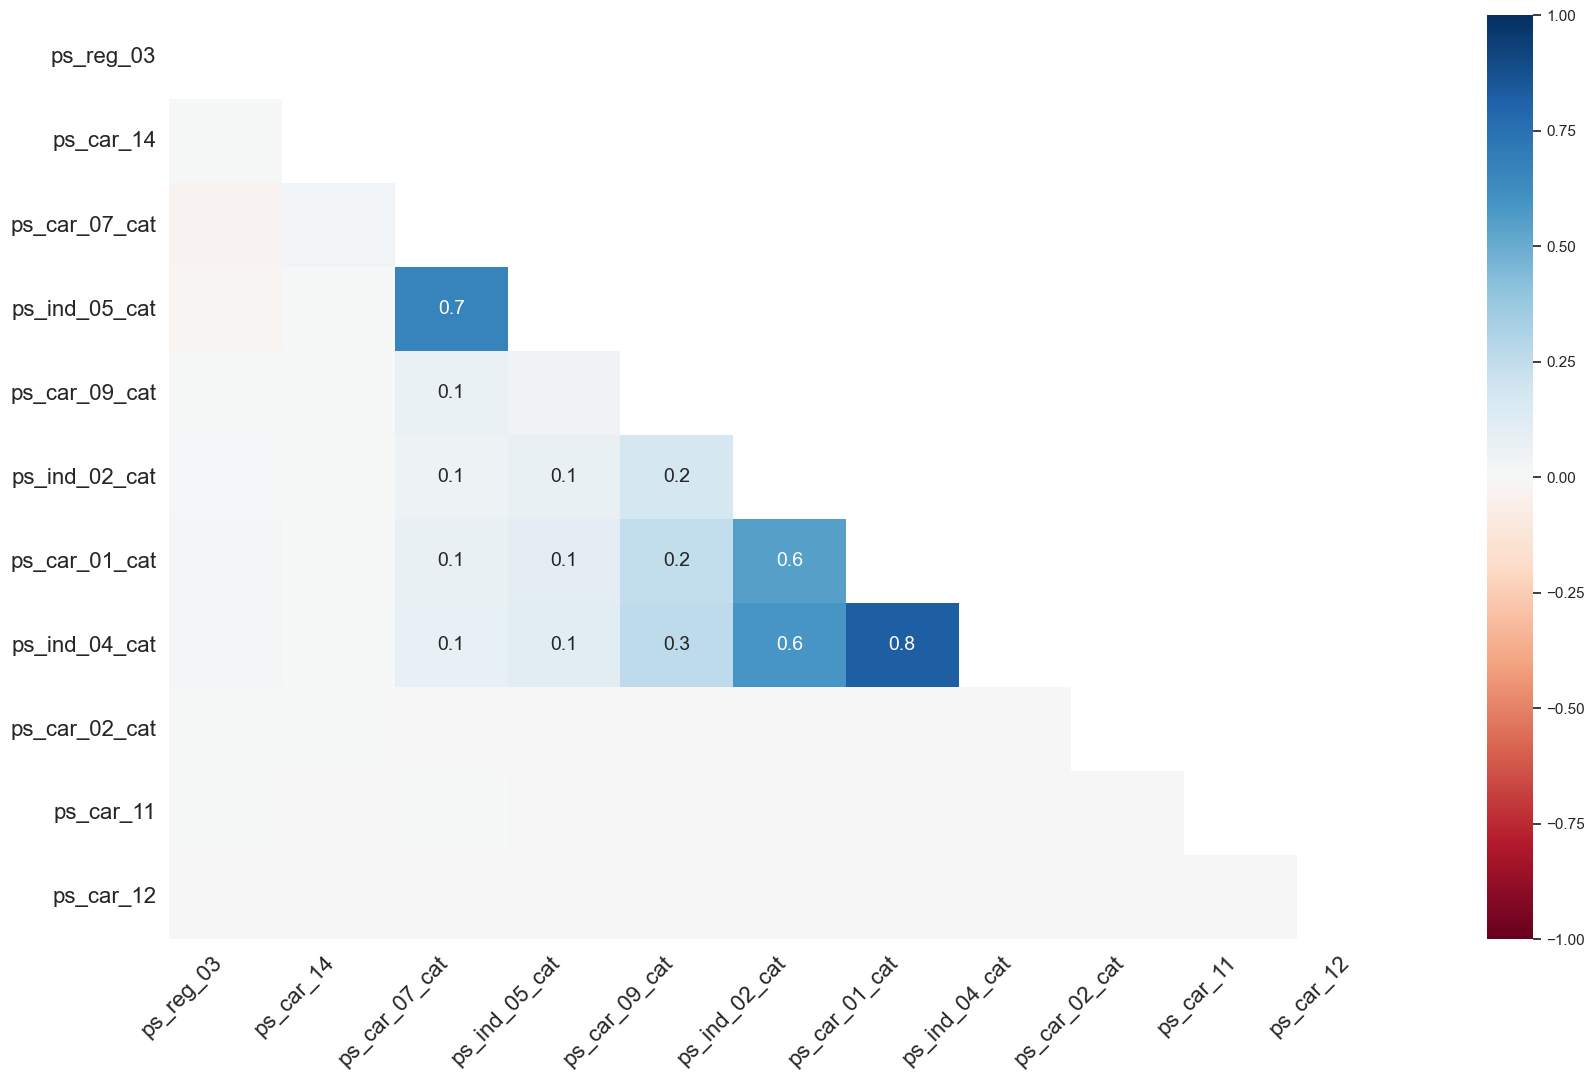

In [7]:
msno.heatmap(fullset[cols_to_imp].replace(-1,np.nan))

In [8]:
set1 = ['ps_ind_05_cat','ps_car_07_cat']
set2 = ['ps_car_01_cat','ps_ind_02_cat','ps_ind_04_cat']
set3 = ['ps_reg_03','ps_car_14']

In [9]:
rf = RandomForestRegressor(n_estimators=10, random_state=123)
imp_mean = IterativeImputer(estimator=rf, missing_values=-1, random_state=0)

In [10]:
df_train[set1]

,ps_ind_05_cat,ps_car_07_cat
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
595207,0,1
595208,0,0
595209,0,1
595210,0,1


In [11]:
set1_imp = imp_mean.fit_transform(df_train[set1])

In [12]:
set1_imp

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [13]:
df_train[set2]

,ps_car_01_cat,ps_ind_02_cat,ps_ind_04_cat
0,10,2,1
1,11,1,0
2,7,4,1
3,7,1,0
4,11,2,1
...,...,...,...
595207,10,1,0
595208,9,1,0
595209,7,1,0
595210,11,2,1


In [14]:
set2_imp = imp_mean.fit_transform(df_train[set2])

In [15]:
set2_imp

array([[10.,  2.,  1.],
       [11.,  1.,  0.],
       [ 7.,  4.,  1.],
       ...,
       [ 7.,  1.,  0.],
       [11.,  2.,  1.],
       [ 7.,  1.,  0.]])

In [16]:
set3_imp = imp_mean.fit_transform(df_train[set3])

/Users/forhheart/ForHHeart/Career/Resume/DS_Project/Safe_Driver_Prediction/venv/lib/python3.9/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


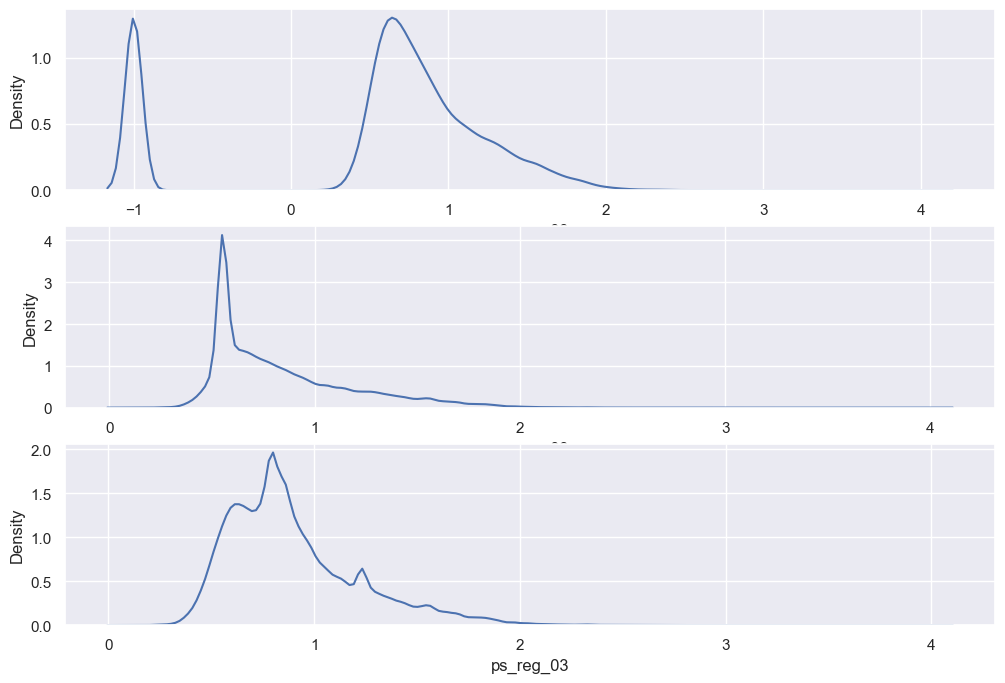

In [17]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
sns.kdeplot(df_train[set3[0]])
plt.subplot(3,1,2)
sns.kdeplot(df_train[set3[0]].replace(-1,np.nan).fillna(df_train[set3[0]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[0]])
plt.show()

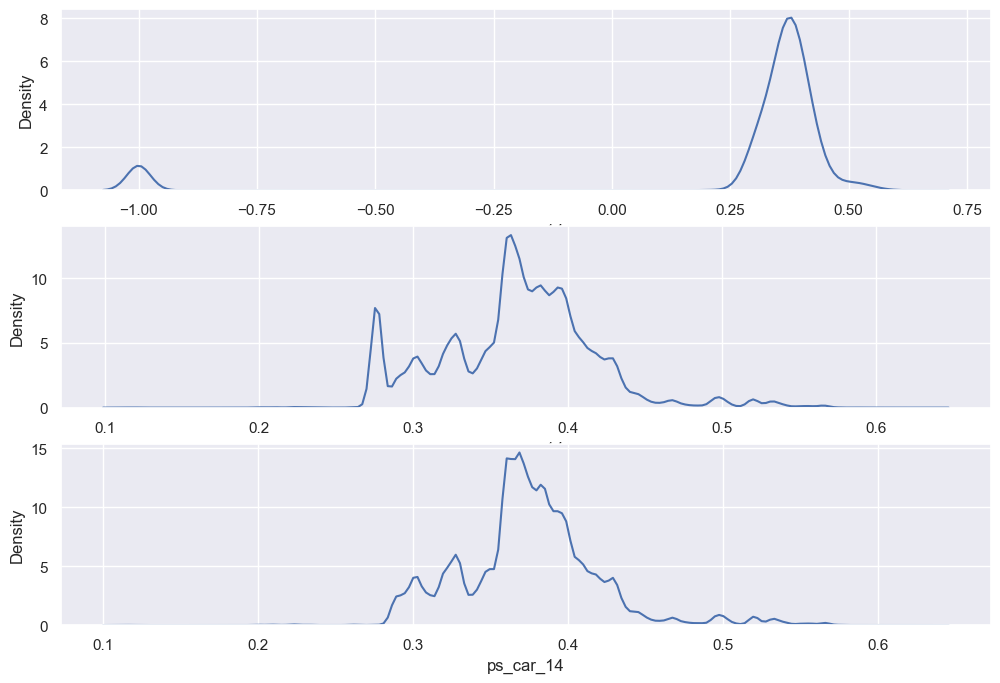

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
sns.kdeplot(df_train[set3[1]])
plt.subplot(3,1,2)
sns.kdeplot(df_train[set3[1]].replace(-1,np.nan).fillna(df_train[set3[1]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[1]])
plt.show()


In [19]:
df_train[set3] = pd.DataFrame(set3_imp,columns = set3)

In [20]:
mode_imputer = SimpleImputer(missing_values = -1, strategy='most_frequent',add_indicator=True)
df_imputed = mode_imputer.fit_transform(df_train[missing_data[4:].index])

In [21]:
missing_data[4:].index

Index(['ps_car_07_cat', 'ps_ind_05_cat', 'ps_car_09_cat', 'ps_ind_02_cat',
       'ps_car_01_cat', 'ps_ind_04_cat', 'ps_car_02_cat', 'ps_car_11',
       'ps_car_12'],
      dtype='object', name='colname')

In [22]:
df_train[missing_data[4:].index] = pd.DataFrame(df_imputed).iloc[:,:len(missing_data[4:].index)]
df_train[missing_data[4:].index] = df_train[missing_data[4:].index].astype('int64')

In [23]:
cols_to_drop = missing_data[missing_data.imputation == 'remove'].index.to_list()
df_train.drop(cols_to_drop,axis=1,inplace=True)

In [24]:
(df_train == -1).sum().sum()

0

In [25]:
df_train.to_csv('../Data/train_imputed.csv')

## Imbalanced Data

In [60]:
df_train = pd.read_csv('../Data/train_imputed.csv')

In [61]:
target_counts = df_train['target'].value_counts()
target_counts

target
0    573518
1     21694
Name: count, dtype: int64

In [62]:
percent_0 = (target_counts[0] / len(df_train)) * 100
percent_1 = (target_counts[1] / len(df_train)) * 100

print(f"The percentage of customers who do not file auto insurance claims is {percent_0:.2f}%")
print(f"The percentage of customers who file auto insurance claims is {percent_1:.2f}%")

The percentage of customers who do not file auto insurance claims is 96.36%
The percentage of customers who file auto insurance claims is 3.64%


<Axes: xlabel='target'>

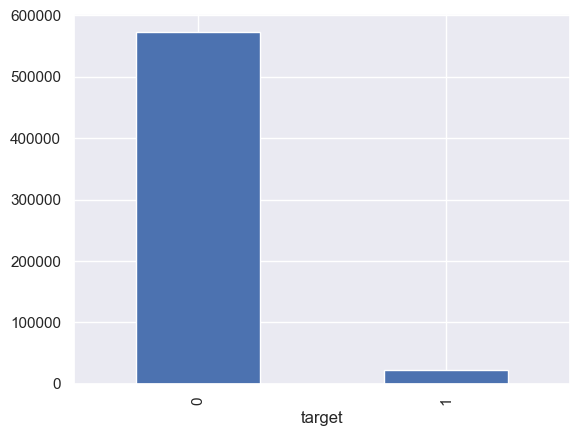

In [63]:
target_counts.plot(kind='bar')

In [29]:
n_comp = 20

X, y = df_train.iloc[:,2:], df_train['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1996)

pca = PCA(n_components=n_comp, random_state=1001)
X_pca = pca.fit_transform(X_train)

In [30]:
# smote_enn = SMOTEENN(random_state=0, smote = SMOTE(k_neighbors=3))
# X_smen, y_smen = smote_enn.fit_resample(X_pca, y_train)

# **Step 3: Feature Engineering**

In [37]:
def woe_iv_encoding(data, feat, target, max_intervals, verbose = False):
    
    feat_bins = pd.qcut(x = data[feat], q = max_intervals, duplicates='drop')
    gi = pd.crosstab(feat_bins,data[target])
    gb = pd.Series(data=data[target]).value_counts()

    bad = gi[1]/gi[0]
    good = gb[1]/gb[0]

    # 计算woe
    woe = np.log(bad) - np.log(good)

    # 计算iv
    iv = (bad-good)*woe

    # 计算整个特征的iv
    f_iv = iv.sum()  # 5.2958917587905745
    if verbose == True:
        print(f"根据当前的间隔数{max_intervals}，特征{feat}所计算的总information value为：{f_iv}")
        print('='*80)

    # 进行映射操作
    dic = iv.to_dict()

    iv_bins = feat_bins.map(dic)  # 连续型变量离散化

    return iv_bins.astype('float64')

In [45]:
continuous_cols = []

In [ ]:
for col in continuous_cols:
    fullset[f"{col}_woe"] = woe_iv_encoding(data = fullset, feat = col, target = 'target', max_intervals = 20)
    #sns.displot(fullset_copy[f"{col}_woe"])

# **Step 4: Model Training and Prediction** 

In [64]:
final_train = pd.read_csv('../Data/train_clean.gz', index_col=0)
final_test = pd.read_csv('../Data/test_clean.gz', index_col=0)

In [47]:
data = pd.read_csv('../Data/fullset_update.gz', index_col=0)

In [65]:
final_train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,744529,0.0,2,1,9,1,0,0,0,1,0,0,0,0,0,0,13,1,0,0,0.1,0.1,0.633936,7,1,-1,2,-1,0,1,1,2,1,104,0,0.422019,0.587297,0.411704,1.414214,0.7,0.7,0.9,3,1,6,1,11,1,10,5,1,2,8,0,0,1,0,0,0
1,673907,0.0,1,1,2,1,0,0,1,0,0,0,0,0,0,0,7,1,0,0,0.7,0.5,1.537449,6,0,-1,0,0,10,1,1,0,1,89,2,0.387298,0.893896,0.410122,3.316625,0.9,0.6,0.3,5,1,8,1,7,2,8,6,4,4,9,1,1,1,1,1,0
2,730796,0.0,7,1,6,0,4,0,0,0,1,0,0,0,0,0,11,1,0,0,0.7,1.0,1.319801,4,1,-1,0,1,11,1,1,0,1,57,2,0.374166,0.721955,0.392428,3.162278,0.3,0.9,0.5,3,1,7,3,7,4,8,3,1,3,7,0,1,1,0,0,0
3,306142,0.0,1,1,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.6,0.2,0.614919,6,1,-1,6,0,11,0,1,0,1,104,0,0.529150,1.039926,0.510588,3.316625,0.0,0.2,0.6,3,1,4,4,6,3,12,5,0,2,9,0,0,1,0,0,0
4,1102701,0.0,6,2,7,1,0,0,1,0,0,0,0,0,0,0,13,1,0,0,0.7,0.5,0.738241,6,1,-1,0,0,1,1,1,0,1,38,3,0.316228,0.694816,0.359861,3.316625,0.8,0.0,0.4,1,2,9,3,7,3,8,6,0,2,9,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144621,1487473,1.0,5,1,7,0,3,0,0,1,0,0,0,0,0,0,8,0,1,0,0.6,0.4,1.537652,11,0,0,0,1,5,1,1,2,1,104,1,0.424264,1.269111,0.384708,3.162278,0.5,0.1,0.5,3,4,9,1,10,2,9,10,1,5,7,0,1,1,0,0,0
144622,1487566,1.0,1,1,5,0,0,0,0,1,0,0,0,0,0,0,4,0,0,1,0.3,0.4,0.633936,11,0,-1,0,-1,15,1,1,2,1,5,2,0.424264,0.756979,0.400000,2.000000,0.3,0.4,0.6,1,1,8,2,9,5,9,9,2,1,5,0,1,0,0,0,0
144623,1487716,1.0,0,1,6,1,0,0,1,0,0,0,0,0,0,0,9,0,1,0,0.9,0.3,0.711952,11,1,0,0,1,7,1,1,1,1,104,3,0.400000,0.970654,0.372424,3.464102,0.5,0.4,0.6,2,2,8,2,8,4,10,3,2,1,6,0,1,1,0,0,0
144624,1487748,1.0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,2,0,0,1,0.6,0.1,0.577170,7,1,1,0,0,11,1,0,2,1,104,2,0.316228,0.876295,0.320780,3.741657,0.5,0.2,0.6,3,0,9,3,10,4,11,5,0,4,4,0,0,1,0,1,0


In [67]:
len(final_test.columns)

59

In [72]:
df_train.columns

Index(['Unnamed: 0', 'id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='object'

In [71]:
final_train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [54]:
data['target'][data['target'] == None]

Series([], Name: target, dtype: float64)

In [32]:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

In [33]:
config = {
    "n_estimators": 400,
    "lr": 0.07,
    "early_stopping_rounds": 50,
    "optimize_rounds": False
}

model = XGBClassifier(    
    n_estimators=config["n_estimators"],
    max_depth=4,
    objective="binary:logistic",
    learning_rate=config["lr"], 
    subsample=.8,
    min_child_weight=6,
    colsample_bytree=.8,
    scale_pos_weight=1.6,
    gamma=10,
    reg_alpha=8,
    reg_lambda=1.3,
)

In [34]:
K = 10
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(1996)

In [42]:
def XGB_gini(df_train, tar_enc = True, pca = False):   
    '''
    df_train: 已处理的训练集数据
    tar_enc: 是否对类别型变量使用target encoding
    pca: 是否使用pca
    '''    
    
    X = df_train.drop('target', axis=1)
    y = df_train['target']
    
    
    y_valid_pred = 0 * y
    y_test_pred = 0
    
    train = pd.concat([X,y],axis=1)
    for i, (train_index, test_index) in enumerate(kf.split(train)):

        # 分成训练集、验证集、测试集

        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()        
        X_test = final_test.copy()
        
        
        if pca:
            n_comp = 20
            print('\nPCA执行中...')
            pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
            X_train = pd.DataFrame(pca.fit_transform(X_train))
            X_valid = pd.DataFrame(pca.transform(X_valid))
            X_test = pd.DataFrame(pca.transform(final_test.copy()))
        print( f"\n{i}折交叉验证： ")
        
        if pca == False:
            if tar_enc == True:
                f_cat = [f for f in X.columns if '_cat' in f and 'tar_enc' not in  f]
                for f in f_cat:
                    X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                                    trn_series=X_train[f],
                                                                    val_series=X_valid[f],
                                                                    tst_series=X_test[f],
                                                                    target=y_train,
                                                                    min_samples_leaf=100,
                                                                    smoothing=10,
                                                                    noise_level=0.01
                                                                    )

    #     from category_encoders.target_encoder import TargetEncoder
    #     tar_enc = TargetEncoder(cols = f_cat).fit(X_train,y_train)
    #     X_train = tar_enc.transform(X_train) # 转换训练集
    #     X_test = tar_enc.transform(X_test) # 转换测试集


            X_train.drop(f_cat,axis=1,inplace=True)
            X_valid.drop(f_cat,axis=1,inplace=True)
            X_test.drop(f_cat,axis=1,inplace=True)


        # 对于当前折，跑XGB
        if config["optimize_rounds"]:
            eval_set=[(X_valid,y_valid)]
            fit_model = model.fit( X_train, y_train, 
                                   eval_set=eval_set,
                                   eval_metric=gini_xgb,
                                   early_stopping_rounds=config["early_stopping_rounds"],
                                   verbose=False
                                 )
            print( "  Best N trees = ", model.best_ntree_limit )
            print( "  Best gini = ", model.best_score )
        else:
            fit_model = model.fit( X_train, y_train )

        # 生成验证集的预测结果
        pred = fit_model.predict_proba(X_valid)[:,1]
        print( "  normalized gini coefficent = ", eval_gini(y_valid, pred) )
        y_valid_pred.iloc[test_index] = pred

        # 累积计算测试集预测结果
        y_test_pred += fit_model.predict_proba(X_test)[:,1]

        del X_test, X_train, X_valid, y_train

    y_test_pred /= K  # 取各fold结果均值

    print( "\n整个训练集（合并）的normalized gini coefficent:" )
    print( "  final normalized gini coefficent = ", eval_gini(y, y_valid_pred) )
    
    return y_test_pred,eval_gini(y, y_valid_pred)

In [48]:
y_test_pred, gini_score = XGB_gini(df_train = data, tar_enc=True)


0折交叉验证： 


KeyError: 'ps_ind_02_cat'

# **Step 5: Submission**

In [ ]:
submission = pd.DataFrame()
submission['id'] = final_test.index.values
submission['target'] = y_test_pred
submission.to_csv('xgb_submit.csv', float_format='%.6f', index=False)